## Prediction of TTF

In this section, we're gonna try and predict TTF using regression models, because it's a regression problem and not a classification one. The models that are used here are :

- Linear Regression
- LASSO: (Least Absolute Shrinkage and Selection Operator) is a regularized version of least squares
regression. It minimizes the sum of squared errors while also penalizing the L1 norm (sum of absolute
values) of the coefficients.
- Ridge Regression: Ridge Regression is a technique for analyzing multiple regression data that suffer from
multicollinearity. By adding a degree of bias to the regression estimates, ridge regression reduces the
standard errors.
- Polynomial Regression: is a form of regression analysis in which the relationship between the independent
variable x and the dependent variable y is modeled as an nth degree polynomial in x
- Decision Trees: learn in a hierarchical fashion by repeatedly splitting the dataset into separate branches
that maximize the information gain of each split. In regression tree, the value obtained by terminal nodes
in the training data is the mean response of observation falling in that region, whereas in classification
tree, the value (class) obtained by terminal node in the training data is the mode of observations falling
in that region.
- Random Forests: are an ensemble learning method for classification, regression and other tasks, that
operate by constructing a multitude of decision trees at training time and outputting the class that is the
mode of the classes (classification) or mean prediction (regression) of the individual trees.


Adding that each and every model is gonna be trained on:

- Original features ( after extracting the NaN features and the constant ones).
- Original features + Features added ( rolling mean and rolling std).
- High correlated features with TTF.

Let's begin by importing the libraries needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, RFECV

Let's load our Data saved in CSV previously.

In [2]:
d_train = pd.read_csv('sample_data/train.csv')
d_train.head()

id  cycle  setting1  setting2      s2       s3       s4     s6      s7  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  21.61  554.36   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  21.61  553.75   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  21.61  554.26   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  21.61  554.45   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  21.61  554.00   

        s8  ...      sd12      sd13      sd14      sd15      sd17      sd20  \
0  2388.06  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  2388.04  ...  0.438406  0.035355  5.041671  0.008697  0.000000  0.042426   
2  2388.08  ...  0.404475  0.026458  3.717450  0.007640  1.154701  0.055076   
3  2388.11  ...  0.495950  0.029439  3.050906  0.028117  1.000000  0.076322   
4  2388.06  ...  0.432574  0.025884  2.651326  0.025953  1.095445  0.073621   

       sd21  TTF  BNC  MCC  
0  0.000000  191    0    0  
1  0.003253  190    0    0  
2  0.044573  189    0    0  
3  0.037977  188    0    0  
4  0.033498  187    0    0  

[5 rows x 52 columns]

In [3]:
d_test = pd.read_csv('sample_data/test.csv')
d_test.head()

id  cycle  setting1  setting2      s2       s3       s4     s6      s7  \
0   1     31   -0.0006    0.0004  642.58  1581.22  1398.91  21.61  554.42   
1   2     49    0.0018   -0.0001  642.55  1586.59  1410.83  21.61  553.52   
2   3    126   -0.0016    0.0004  642.88  1589.75  1418.89  21.61  552.59   
3   4    106    0.0012    0.0004  642.78  1594.53  1406.88  21.61  552.64   
4   5     98   -0.0013   -0.0004  642.27  1589.94  1419.36  21.61  553.29   

        s8  ...      sd12      sd13      sd14      sd15      sd17      sd20  \
0  2388.08  ...  0.261591  0.028810  3.302941  0.021174  0.707107  0.124016   
1  2388.10  ...  0.450255  0.008367  1.370062  0.011429  1.095445  0.069785   
2  2388.16  ...  0.418234  0.029665  2.979090  0.030924  0.836660  0.143631   
3  2388.13  ...  0.363291  0.027019  0.622953  0.021249  1.341641  0.126372   
4  2388.10  ...  0.260231  0.023022  1.923609  0.009627  0.547723  0.091924   

       sd21  TTF  BNC  MCC  
0  0.025037  112    0    0  
1  0.027820   98    0    0  
2  0.018966   69    0    0  
3  0.021106   82    0    0  
4  0.101100   91    0    0  

[5 rows x 52 columns]

In [4]:
d_train.columns

Index(['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21',
       'av2', 'av3', 'av4', 'av6', 'av7', 'av8', 'av9', 'av11', 'av12', 'av13',
       'av14', 'av15', 'av17', 'av20', 'av21', 'sd2', 'sd3', 'sd4', 'sd6',
       'sd7', 'sd8', 'sd9', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd17',
       'sd20', 'sd21', 'TTF', 'BNC', 'MCC'],
      dtype='object')

To make it easy to train models on different set of features, a variable to hold the set of features required was used to subset the original dataframes.

In [78]:
original_features=['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

features_added= ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21',
       'av2', 'av3', 'av4', 'av6', 'av7', 'av8', 'av9', 'av11', 'av12', 'av13',
       'av14', 'av15', 'av17', 'av20', 'av21', 'sd2', 'sd3', 'sd4', 'sd6',
       'sd7', 'sd8', 'sd9', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd17',
       'sd20', 'sd21']

features_highcorrel=['av21','av20','av12','av7','s12','s7','s21','s20']

#the variable features that  hold the set of features
#we'll begin trainin on original features
features=original_features

X_train = d_train[features]
y_train = d_train['TTF']

X_test = d_test[features]
y_test = d_test['TTF']

Now as we gonna use various models, we're gonna create some functions that help us do:
- Calculate regression metrics
- Plot the features' importance
- Plot the regression residuals

Let's create the metrics calcul function

In [10]:
def get_regression_metrics(model, actual, predicted):
   regr_metrics = {'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)}

    #return reg_metrics

   df_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
   df_metrics.columns = [model]
   return df_metrics

Now let's create the features'importance function.


In [15]:
def features_importance(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights': weights}, index=feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px, py))
    label = ' Coefficients' if weights_type == 'c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

Now let's create the regression residuals function.

In [17]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

# **A. Training on original features:**

## **A.1 Linear Regression:**

Let us now model and evaluate some regression algorithms

In [19]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)



Now as we trained, let's evaluate.

In [20]:
print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.580, R^2 test: 0.405


Linear Regression
Root Mean Squared Error          32.041095
Mean Absolute Error              25.591780
R^2                               0.405495
Explained Variance                0.665297

Let's now plot the features' importance in the regression model.

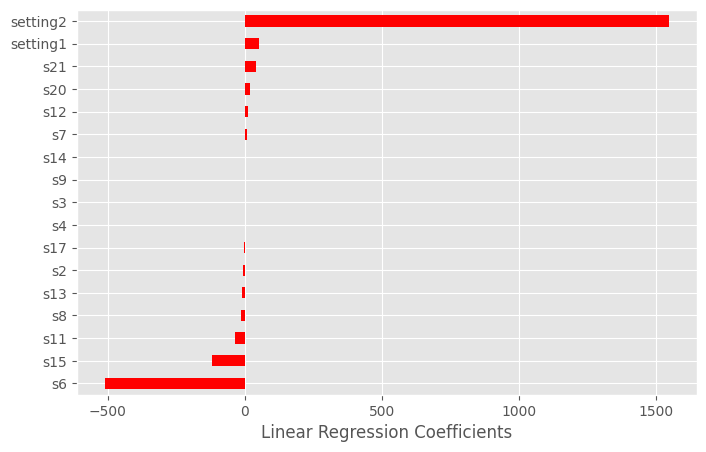

In [22]:
features_importance('Linear Regression', linreg.coef_, X_train.columns, 'c')

Let's plot the residuals.

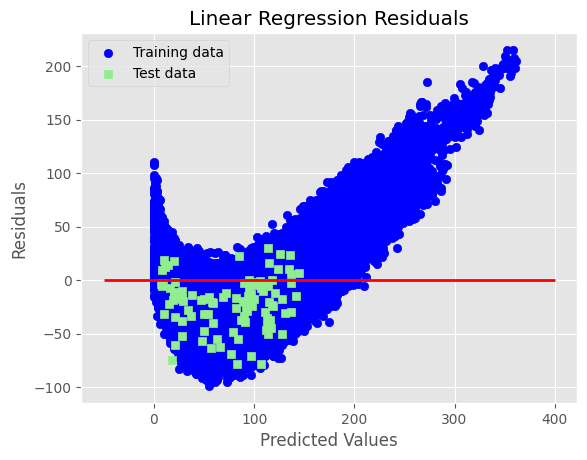

In [23]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

## **A.2 LASSO:**


In the context of the Lasso regression model, which is a type of linear regression, **alpha** is a parameter that controls the amount of regularization applied to the model. Regularization is a technique used to prevent overfitting by adding a penalty to the loss function.

The Lasso regression specifically uses L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This can lead to some coefficients being exactly zero when the penalty is sufficiently large. In other words, Lasso can perform feature selection by shrinking some coefficients to zero, effectively removing those features from the model.

The alpha parameter controls the strength of this penalty:

When alpha is 0, Lasso regression produces the same coefficients as a standard linear regression.
As alpha increases, the impact of the regularization increases, leading to smaller coefficients overall, and more coefficients being set to zero.
A very high value of alpha will lead to underfitting, as the model becomes too simple, potentially ignoring important features.
Choosing the right value of alpha is crucial and is typically done via cross-validation, where different values of alpha are tested, and the one that results in the best model performance is selected. The LassoCV class in the scikit-learn library can be used to perform this kind of search efficiently.

Lets find this alpha.

In [25]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_
print("Best alpha value found:", best_alpha)

Best alpha value found: 0.5933510800729399


This is the best alpha, let's now use it to fit our model.

In [26]:
lasso = linear_model.Lasso(alpha=0.5933510800729399)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics

R^2 training: 0.571, R^2 test: 0.334


LASSO
Root Mean Squared Error  33.911243
Mean Absolute Error      27.259315
R^2                       0.334071
Explained Variance        0.637001

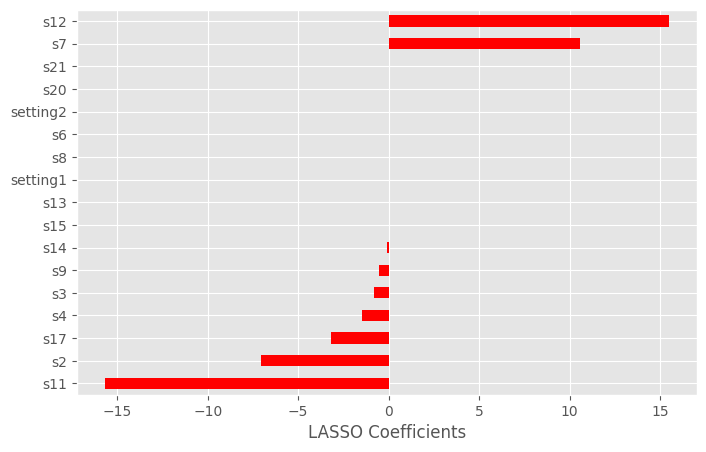

In [27]:
features_importance('LASSO', lasso.coef_, X_train.columns, 'c')

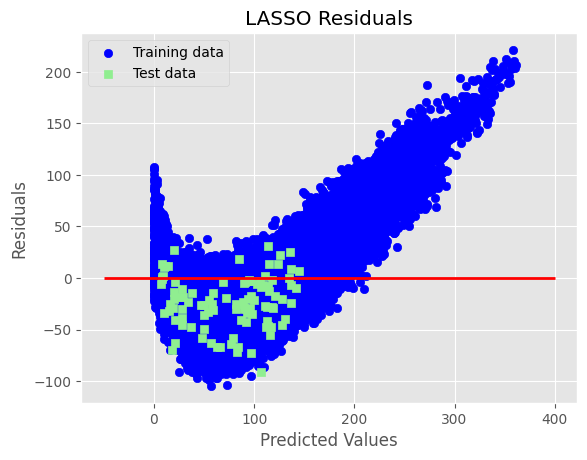

In [28]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

## **A.3 Ridge Regression :**

Just like with Lasso, we can use Ridge regression with built-in cross-validation to find the optimal value of the alpha parameter. In Ridge regression, alpha controls the strength of L2 regularization, which adds a penalty equal to the square of the magnitude of coefficients. This type of regularization tends to distribute the error among all the coefficients and is less likely to set coefficients to zero.

To implement this, we will use the RidgeCV class from the scikit-learn library.

In [31]:
from sklearn.linear_model import RidgeCV
alphas = [0.001, 0.01, 0.1, 1, 10, 100] #common to use values on a log scale
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
print("Best alpha value found:", best_alpha)

Best alpha value found: 1.0


In [32]:
rdg = linear_model.Ridge(alpha=1.0)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.579, R^2 test: 0.408


Ridge Regression
Root Mean Squared Error         31.966557
Mean Absolute Error             25.554325
R^2                              0.408258
Explained Variance               0.668870

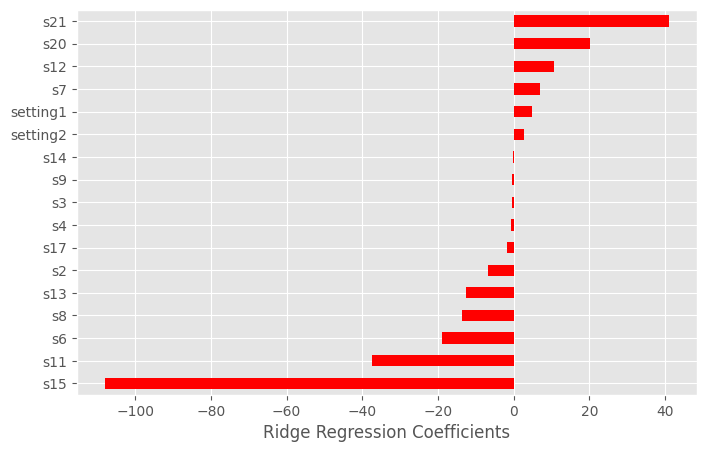

In [33]:
features_importance('Ridge Regression', rdg.coef_, X_train.columns, 'c')


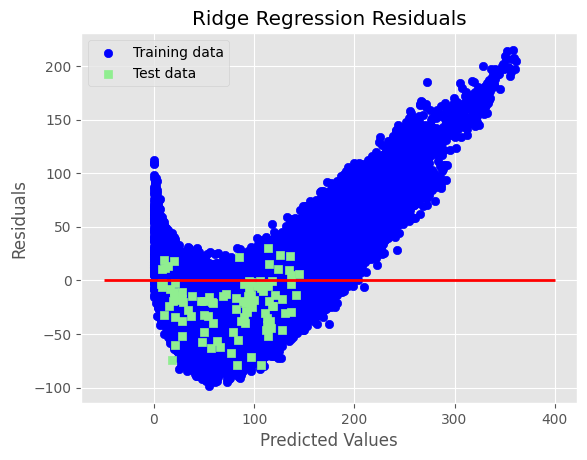

In [34]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)


## **A.4 Polynomial Regression :**


Polynomial regression is a form of regression analysis in which the relationship between the independent variable $x$ and the dependent variable $y$ is modeled as an nth degree polynomial. Polynomial regression fits a nonlinear relationship between the value of $x$ and the corresponding conditional mean of $y$, denoted $E(y | x)$, and has been used to describe nonlinear phenomena such as the growth rate of tissues, the distribution of carbon isotopes in lake sediments, and the progression of disease epidemics.

The basic equation of a polynomial regression is:

$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_n x^n + \epsilon $$

Here:
- $y$ is the dependent variable.
- $x$ is the independent variable.
- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are the coefficients.
- $n$ is the degree of the polynomial.
- $\epsilon$ is the error term.

## Hyperparameter: Degree

The "degree" of the polynomial is a hyperparameter. It determines the flexibility of the polynomial regression model. Specifically:

1. **Degree 1**: The model is just a straight line (linear regression).
2. **Higher Degrees**: As you increase the degree of the polynomial, the model becomes more flexible and can fit more complex data patterns.


Here we're gonna choose degree=2, and transform the data to polynomial features using Polynomial features, and then use Linear regression on these polynomial features.

In [35]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.627, R^2 test: 0.427


Polynomial Regression
Root Mean Squared Error              31.461080
Mean Absolute Error                  23.993950
R^2                                   0.426824
Explained Variance                    0.640990

Here we couldn't use the features_importance function as it takes X.traincolumns as an argument, but here we transformed the features to polynomial.

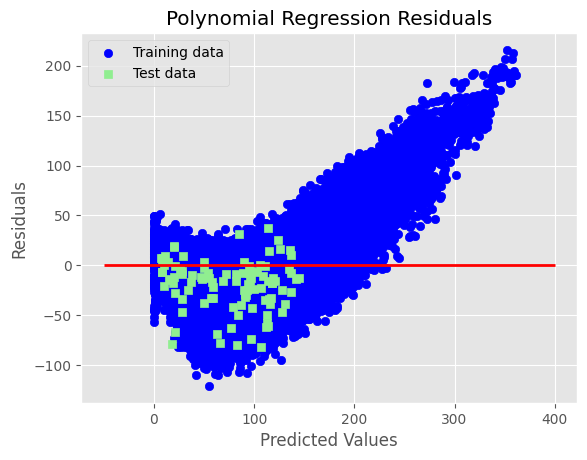

In [37]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)


## **A.5 Decision Tree regressor:**

The max depth in the Decision tree is a hyperparameter. We're gonna fix it to 10, as we have other parameters to change ( like the training features and the models).

In [39]:
dtrg = DecisionTreeRegressor(max_depth=10, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 0.692, R^2 test: 0.355


Decision Tree Regression
Root Mean Squared Error                 33.368578
Mean Absolute Error                     24.506921
R^2                                      0.355214
Explained Variance                       0.554069

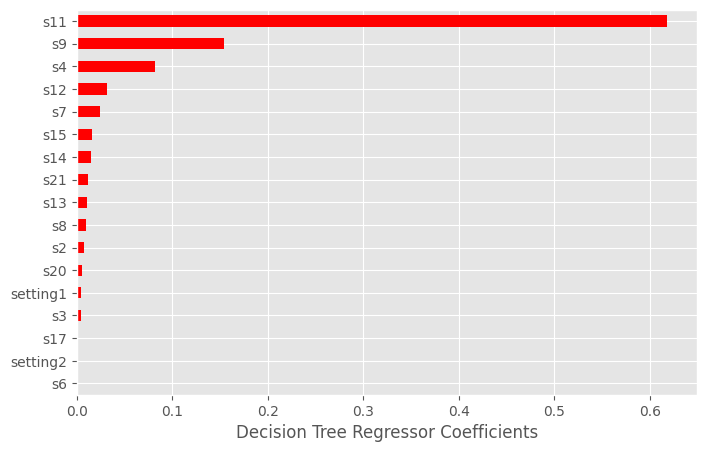

In [41]:
features_importance('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 'c' )


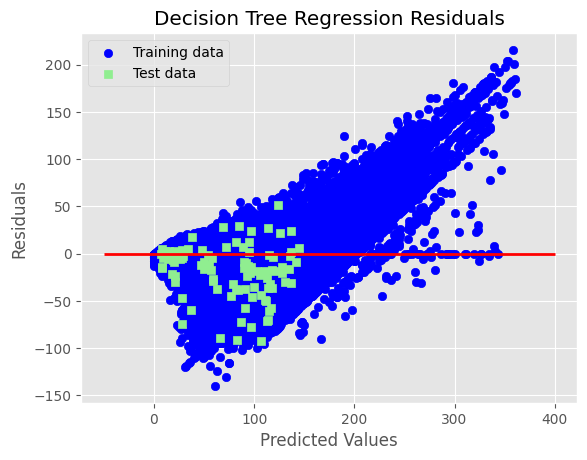

In [42]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)


Let's visualize the tree.

In [47]:
dot_data = export_graphviz(dtrg, out_file=None,
                           feature_names=X_train.columns,
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")

graph

## **A.6 Random Forest Regressor**

Choosing the best hyperparameters for a RandomForestRegressor (or any machine learning model) is typically done through a process known as hyperparameter tuning or optimization. This process involves searching through a range of hyperparameter values to find the combination that performs the best according to a specified metric, usually on a validation set or via cross-validation.

For a RandomForestRegressor, key hyperparameters include n_estimators, max_features, max_depth, and others. Let's use RandomizedSearchCV to find the best hyperparameters.

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV



param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 8, 10],
  }

rf = RandomForestRegressor(random_state=1)

rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                           n_iter=10, cv=3, verbose=2, random_state=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print("Best parameters found: ", rf_cv.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10}


We first notice that it took too long to try the different combinations and just for 10 iterations.

In [51]:
rf = RandomForestRegressor(n_estimators=300, max_features='sqrt', max_depth=10, n_jobs=-1, random_state=1)

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.712, R^2 test: 0.440


Random Forest Regression
Root Mean Squared Error                 31.086142
Mean Absolute Error                     22.780593
R^2                                      0.440405
Explained Variance                       0.651546

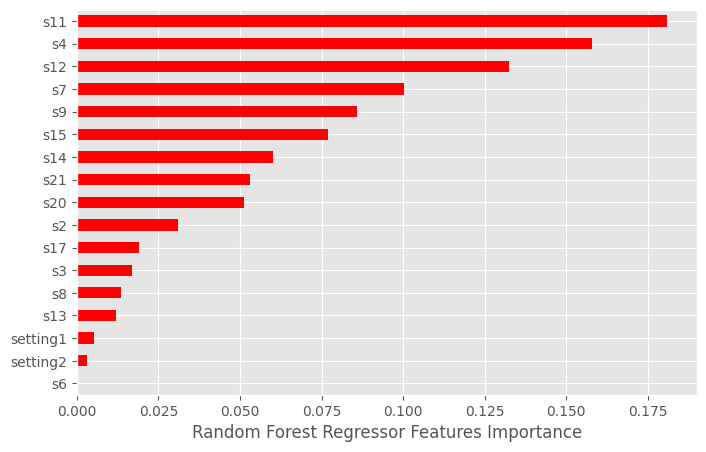

In [52]:
features_importance('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )


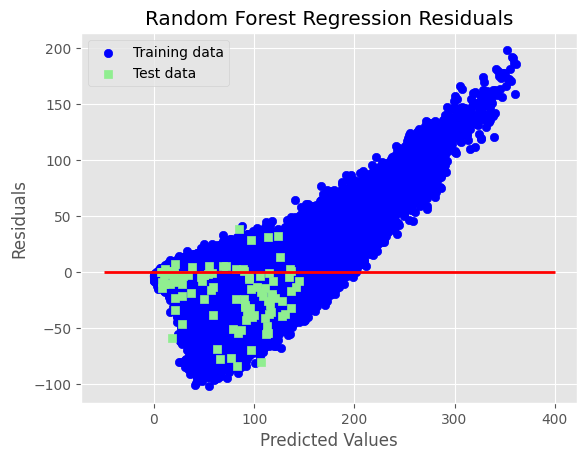

In [53]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)


##**Summary:**


Let us first compare the models.

In [54]:
reg_metrics_org = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics], axis=1)
reg_metrics_org

Linear Regression      LASSO  Ridge Regression  \
Root Mean Squared Error          32.041095  33.911243         31.966557   
Mean Absolute Error              25.591780  27.259315         25.554325   
R^2                               0.405495   0.334071          0.408258   
Explained Variance                0.665297   0.637001          0.668870   

                         Decision Tree Regression  Polynomial Regression  \
Root Mean Squared Error                 33.368578              31.461080   
Mean Absolute Error                     24.506921              23.993950   
R^2                                      0.355214               0.426824   
Explained Variance                       0.554069               0.640990   

                         Random Forest Regression  
Root Mean Squared Error                 31.086142  
Mean Absolute Error                     22.780593  
R^2                                      0.440405  
Explained Variance                       0.651546

- Non-linear regression models like Polynomial and Random Forest performed better than linear models like Linear regression, LASSO and Ridge regression. Random Forest clearly outperformed other models scoring RMSE of 31.08 cycles, i.e. the model predicts TTF within average error range of ±31.08 cycles.
- Regression residuals were not randomly spread across the average value of the residuals. This could be improved by fixing the data (using the other type of features).
- For every model, there is a different set of important features, but we notice that s11 and setting2 are always important.

# **B. Training on original features + added features:**

Now let's train and evaluate our models , but this time adding the features that we added on the data preparation section.

Let's change the features variable in the code below.

In [79]:
original_features=['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

features_added= ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21',
       'av2', 'av3', 'av4', 'av6', 'av7', 'av8', 'av9', 'av11', 'av12', 'av13',
       'av14', 'av15', 'av17', 'av20', 'av21', 'sd2', 'sd3', 'sd4', 'sd6',
       'sd7', 'sd8', 'sd9', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd17',
       'sd20', 'sd21']

features_highcorrel=['av21','av20','av12','av7','s12','s7','s21','s20']

#the variable features that  hold the set of features
#we'll begin trainin on original features
features=features_added #here changed

X_train = d_train[features]
y_train = d_train['TTF']

X_test = d_test[features]
y_test = d_test['TTF']

## **B.1 Linear Regression:**

Let us now model and evaluate some regression algorithms

In [80]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)



Now as we trained, let's evaluate.

In [81]:
print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.595, R^2 test: 0.347


Linear Regression
Root Mean Squared Error          33.567598
Mean Absolute Error              27.188280
R^2                               0.347499
Explained Variance                0.630618

Let's now plot the features' importance in the regression model.

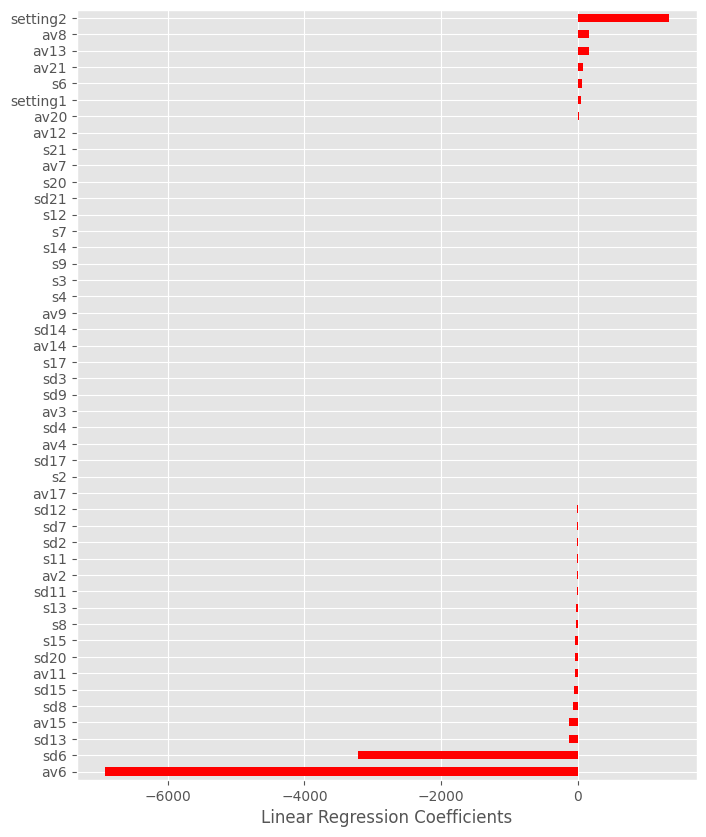

In [82]:
features_importance('Linear Regression', linreg.coef_, X_train.columns, 'c')

Let's plot the residuals.

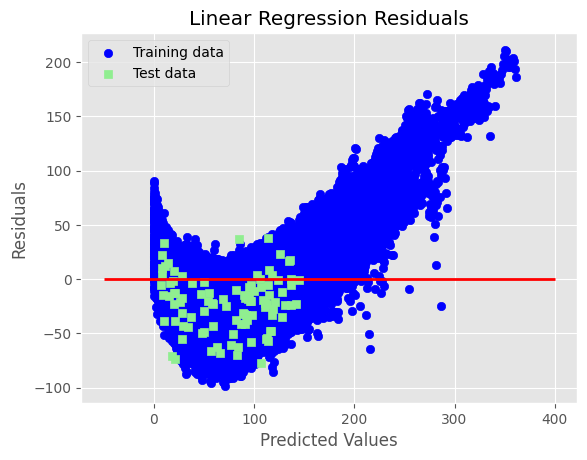

In [83]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

## **B.2 LASSO:**


In the context of the Lasso regression model, which is a type of linear regression, **alpha** is a parameter that controls the amount of regularization applied to the model. Regularization is a technique used to prevent overfitting by adding a penalty to the loss function.

The Lasso regression specifically uses L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This can lead to some coefficients being exactly zero when the penalty is sufficiently large. In other words, Lasso can perform feature selection by shrinking some coefficients to zero, effectively removing those features from the model.

The alpha parameter controls the strength of this penalty:

When alpha is 0, Lasso regression produces the same coefficients as a standard linear regression.
As alpha increases, the impact of the regularization increases, leading to smaller coefficients overall, and more coefficients being set to zero.
A very high value of alpha will lead to underfitting, as the model becomes too simple, potentially ignoring important features.
Choosing the right value of alpha is crucial and is typically done via cross-validation, where different values of alpha are tested, and the one that results in the best model performance is selected. The LassoCV class in the scikit-learn library can be used to perform this kind of search efficiently.

Lets find this alpha.

In [84]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_
print("Best alpha value found:", best_alpha)

Best alpha value found: 0.5933510800729399


This is the best alpha, let's now use it to fit our model.

In [85]:
lasso = linear_model.Lasso(alpha=0.5933510800729399)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics

R^2 training: 0.583, R^2 test: 0.327


LASSO
Root Mean Squared Error  34.093756
Mean Absolute Error      27.796190
R^2                       0.326884
Explained Variance        0.629381

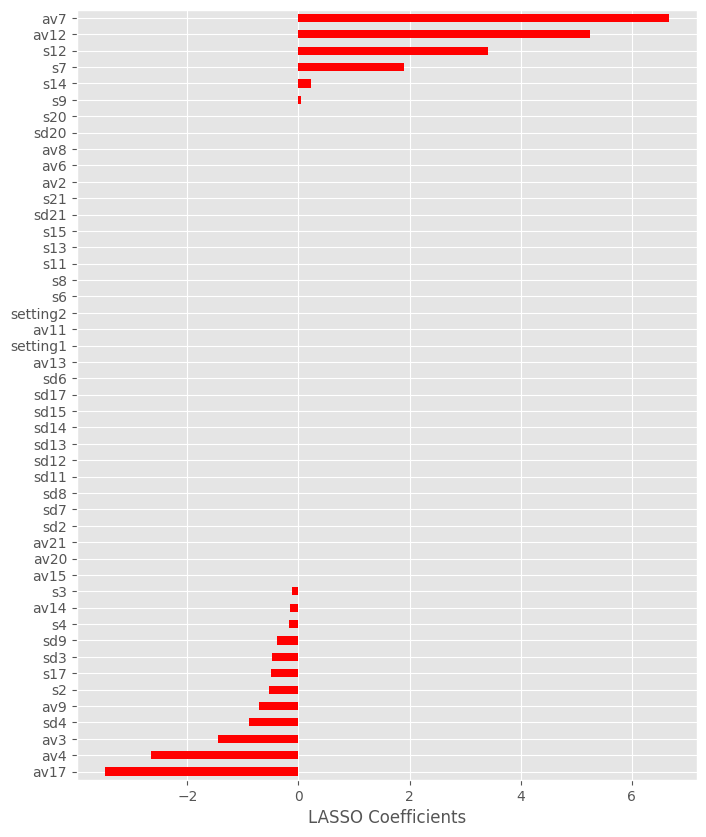

In [86]:
features_importance('LASSO', lasso.coef_, X_train.columns, 'c')

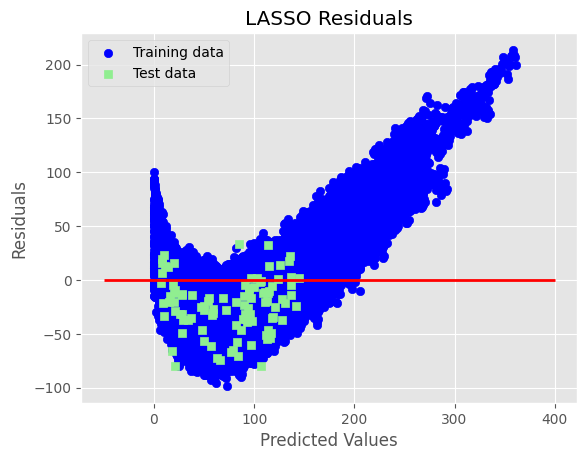

In [87]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

## **B.3 Ridge Regression :**

Just like with Lasso, we can use Ridge regression with built-in cross-validation to find the optimal value of the alpha parameter. In Ridge regression, alpha controls the strength of L2 regularization, which adds a penalty equal to the square of the magnitude of coefficients. This type of regularization tends to distribute the error among all the coefficients and is less likely to set coefficients to zero.

To implement this, we will use the RidgeCV class from the scikit-learn library.

In [88]:
from sklearn.linear_model import RidgeCV
alphas = [0.001, 0.01, 0.1, 1, 10, 100] #common to use values on a log scale
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
print("Best alpha value found:", best_alpha)

Best alpha value found: 1.0


In [89]:
rdg = linear_model.Ridge(alpha=1.0)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.594, R^2 test: 0.346


Ridge Regression
Root Mean Squared Error         33.609873
Mean Absolute Error             27.173600
R^2                              0.345855
Explained Variance               0.631833

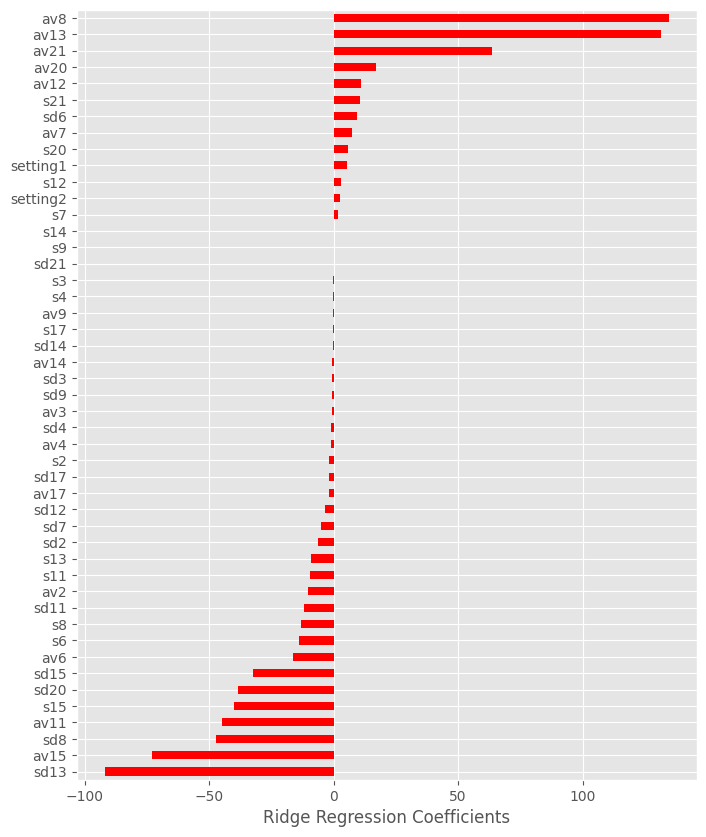

In [90]:
features_importance('Ridge Regression', rdg.coef_, X_train.columns, 'c')


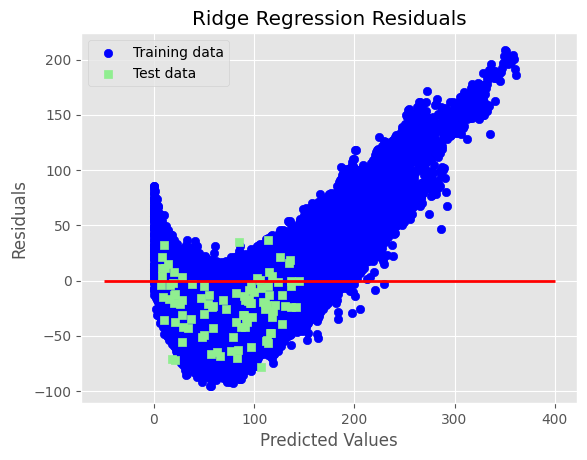

In [91]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)


## **B.4 Polynomial Regression :**


Polynomial regression is a form of regression analysis in which the relationship between the independent variable $x$ and the dependent variable $y$ is modeled as an nth degree polynomial. Polynomial regression fits a nonlinear relationship between the value of $x$ and the corresponding conditional mean of $y$, denoted $E(y | x)$, and has been used to describe nonlinear phenomena such as the growth rate of tissues, the distribution of carbon isotopes in lake sediments, and the progression of disease epidemics.

The basic equation of a polynomial regression is:

$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_n x^n + \epsilon $$

Here:
- $y$ is the dependent variable.
- $x$ is the independent variable.
- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are the coefficients.
- $n$ is the degree of the polynomial.
- $\epsilon$ is the error term.

**Hyperparameter: Degree**

The "degree" of the polynomial is a hyperparameter. It determines the flexibility of the polynomial regression model. Specifically:

1. **Degree 1**: The model is just a straight line (linear regression).
2. **Higher Degrees**: As you increase the degree of the polynomial, the model becomes more flexible and can fit more complex data patterns.


Here we're gonna choose degree=2, and transform the data to polynomial features using Polynomial features, and then use Linear regression on these polynomial features.

In [92]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.670, R^2 test: 0.317


Polynomial Regression
Root Mean Squared Error              34.337596
Mean Absolute Error                  26.800907
R^2                                   0.317221
Explained Variance                    0.538597

Here we couldn't use the features_importance function as it takes X.traincolumns as an argument, but here we transformed the features to polynomial.

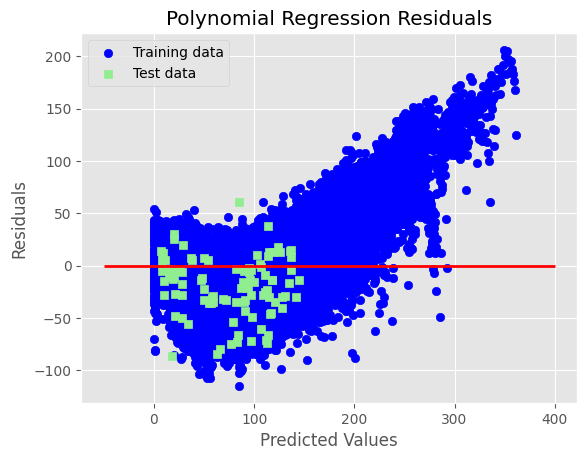

In [93]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)


## **B.5 Decision Tree regressor:**

The max depth in the Decision tree is a hyperparameter. We're gonna fix it to 10, as we have other parameters to change ( like the training features and the models).

In [94]:
dtrg = DecisionTreeRegressor(max_depth=10, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 0.744, R^2 test: 0.071


Decision Tree Regression
Root Mean Squared Error                 40.050578
Mean Absolute Error                     26.948377
R^2                                      0.071123
Explained Variance                       0.304820

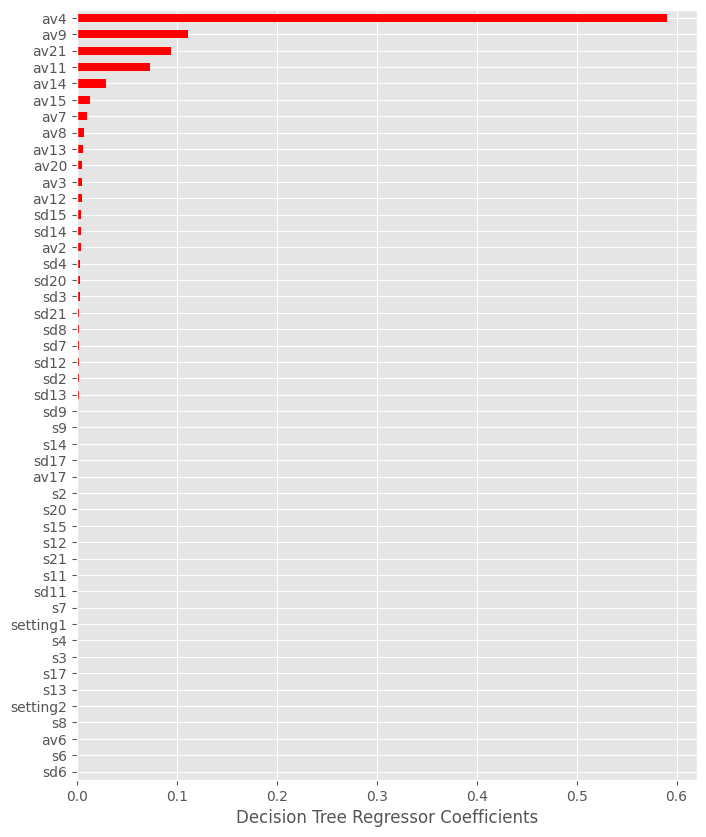

In [95]:
features_importance('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 'c' )


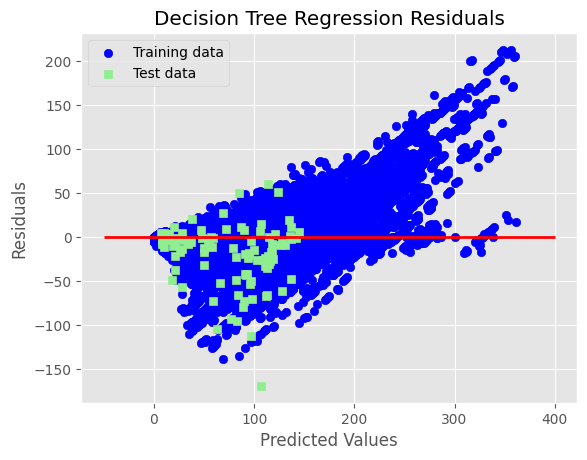

In [96]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)


Let's visualize the tree.

In [97]:
dot_data = export_graphviz(dtrg, out_file=None,
                           feature_names=X_train.columns,
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")

graph

## **B.6 Random Forest Regressor**

Choosing the best hyperparameters for a RandomForestRegressor (or any machine learning model) is typically done through a process known as hyperparameter tuning or optimization. This process involves searching through a range of hyperparameter values to find the combination that performs the best according to a specified metric, usually on a validation set or via cross-validation.

For a RandomForestRegressor, key hyperparameters include n_estimators, max_features, max_depth, and others. Let's use RandomizedSearchCV to find the best hyperparameters.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV



param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 8, 10],
  }

rf = RandomForestRegressor(random_state=1)

rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                           n_iter=10, cv=3, verbose=2, random_state=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print("Best parameters found: ", rf_cv.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10}


We first notice that it took too long to try the different combinations and just for 10 iterations.

In [98]:
rf = RandomForestRegressor(n_estimators=300, max_features='sqrt', max_depth=10, n_jobs=-1, random_state=1)

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.750, R^2 test: 0.428


Random Forest Regression
Root Mean Squared Error                 31.428195
Mean Absolute Error                     23.089121
R^2                                      0.428022
Explained Variance                       0.642285

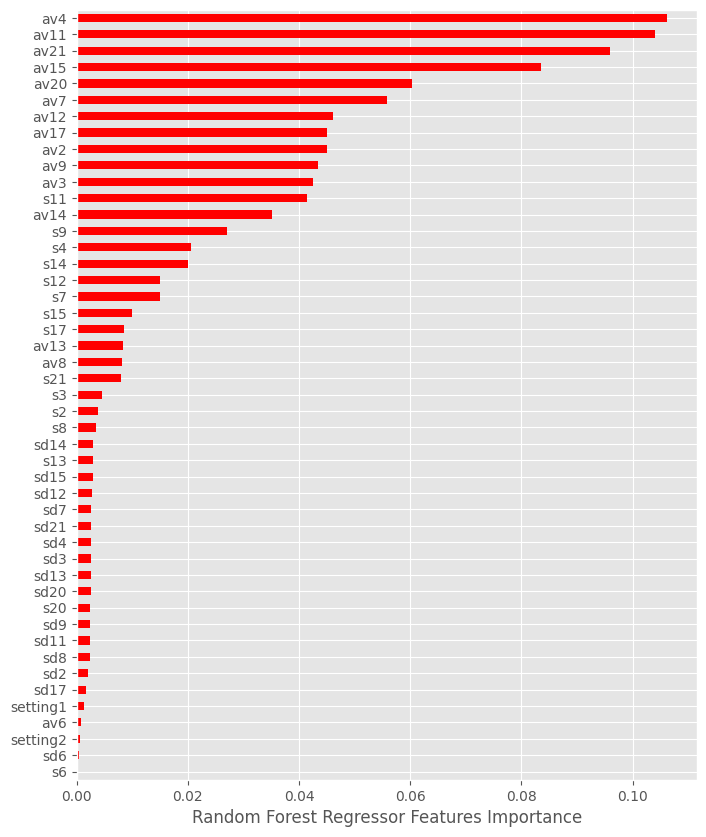

In [99]:
features_importance('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )


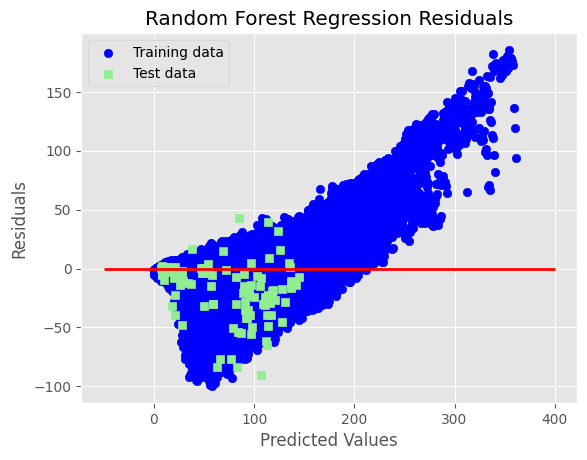

In [100]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)


##**Summary:**


Let us first compare the models.

In [101]:
reg_metrics_org = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics], axis=1)
reg_metrics_org

Linear Regression      LASSO  Ridge Regression  \
Root Mean Squared Error          33.567598  34.093756         33.609873   
Mean Absolute Error              27.188280  27.796190         27.173600   
R^2                               0.347499   0.326884          0.345855   
Explained Variance                0.630618   0.629381          0.631833   

                         Decision Tree Regression  Polynomial Regression  \
Root Mean Squared Error                 40.050578              34.337596   
Mean Absolute Error                     26.948377              26.800907   
R^2                                      0.071123               0.317221   
Explained Variance                       0.304820               0.538597   

                         Random Forest Regression  
Root Mean Squared Error                 31.428195  
Mean Absolute Error                     23.089121  
R^2                                      0.428022  
Explained Variance                       0.642285

- Non-linear model Random Forest performed better than linear models like Linear regression, LASSO and Ridge regression. Once again, Random Forest clearly outperformed other models scoring RMSE of 31.42 cycles, i.e. the model predicts TTF within average error range of ±31.42 cycles.
- Regression residuals were not randomly spread across the average value of the residuals.
- For every model, there is a different set of important features, but we notice that the features added are always the most important features , more than the original ones.

Let's visualize the predictions of the Random Forest model.

In [102]:
rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }

rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

0           1         2           3           4   \
Actual      112.000000   98.000000  69.00000   82.000000   91.000000   
Prediction  173.794108  147.412195  53.91102  112.450423  126.433936   

                   5          6           7           8           9   ...  \
Actual       93.00000   91.00000   95.000000  111.000000   96.000000  ...   
Prediction  134.89145  119.53403  117.648735  134.866118  135.066378  ...   

                   90         91         92         93          94  \
Actual      38.000000  20.000000  85.000000  55.000000  128.000000   
Prediction  21.480441  18.941082  41.791756  58.329355  145.227356   

                    95         96        97       98         99  
Actual      137.000000  82.000000  59.00000  117.000  20.000000  
Prediction  147.349732  88.810528  88.82285  156.517  21.024588  

[2 rows x 100 columns]

# **C. Training on high correlated features with TTF:**

Now let's train and evaluate our models , but this time with the TTF high correlated features.

Let's change the features variable in the code below.

In [103]:
original_features=['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

features_added= ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21',
       'av2', 'av3', 'av4', 'av6', 'av7', 'av8', 'av9', 'av11', 'av12', 'av13',
       'av14', 'av15', 'av17', 'av20', 'av21', 'sd2', 'sd3', 'sd4', 'sd6',
       'sd7', 'sd8', 'sd9', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd17',
       'sd20', 'sd21']

features_highcorrel=['av21','av20','av12','av7','s12','s7','s21','s20']

#the variable features that  hold the set of features
#we'll begin trainin on original features
features=features_highcorrel #here changed

X_train = d_train[features]
y_train = d_train['TTF']

X_test = d_test[features]
y_test = d_test['TTF']

## **C.1 Linear Regression:**

Let us now model and evaluate some regression algorithms

In [104]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)



Now as we trained, let's evaluate.

In [105]:
print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.547, R^2 test: 0.326


Linear Regression
Root Mean Squared Error          34.121522
Mean Absolute Error              26.829372
R^2                               0.325787
Explained Variance                0.546686

Let's now plot the features' importance in the regression model.

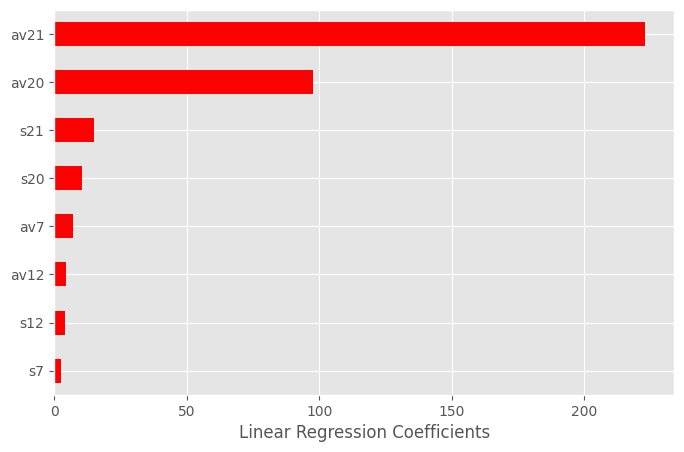

In [106]:
features_importance('Linear Regression', linreg.coef_, X_train.columns, 'c')

Let's plot the residuals.

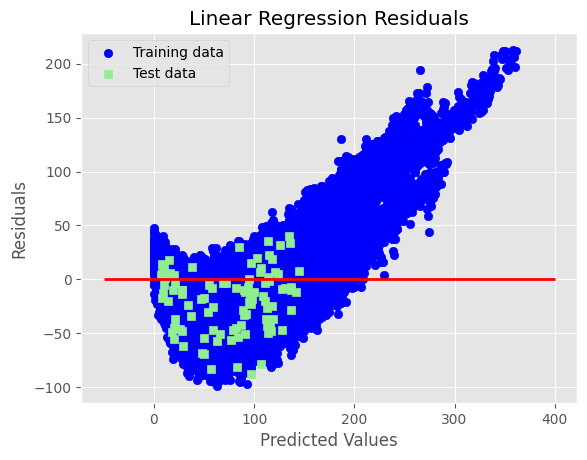

In [107]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

## **C.2 LASSO:**


In the context of the Lasso regression model, which is a type of linear regression, **alpha** is a parameter that controls the amount of regularization applied to the model. Regularization is a technique used to prevent overfitting by adding a penalty to the loss function.

The Lasso regression specifically uses L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This can lead to some coefficients being exactly zero when the penalty is sufficiently large. In other words, Lasso can perform feature selection by shrinking some coefficients to zero, effectively removing those features from the model.

The alpha parameter controls the strength of this penalty:

When alpha is 0, Lasso regression produces the same coefficients as a standard linear regression.
As alpha increases, the impact of the regularization increases, leading to smaller coefficients overall, and more coefficients being set to zero.
A very high value of alpha will lead to underfitting, as the model becomes too simple, potentially ignoring important features.
Choosing the right value of alpha is crucial and is typically done via cross-validation, where different values of alpha are tested, and the one that results in the best model performance is selected. The LassoCV class in the scikit-learn library can be used to perform this kind of search efficiently.

Lets find this alpha.

In [108]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_
print("Best alpha value found:", best_alpha)

Best alpha value found: 0.04006631512003925


This is the best alpha, let's now use it to fit our model.

In [109]:
lasso = linear_model.Lasso(alpha=0.04006631512003925)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics

R^2 training: 0.547, R^2 test: 0.322


LASSO
Root Mean Squared Error  34.210798
Mean Absolute Error      26.847588
R^2                       0.322254
Explained Variance        0.544830

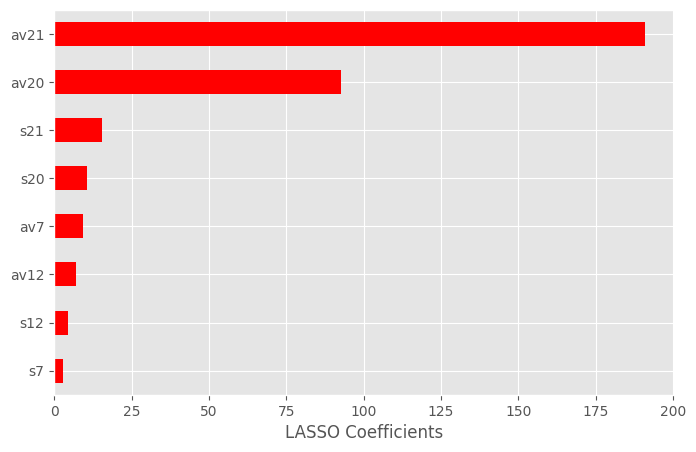

In [110]:
features_importance('LASSO', lasso.coef_, X_train.columns, 'c')

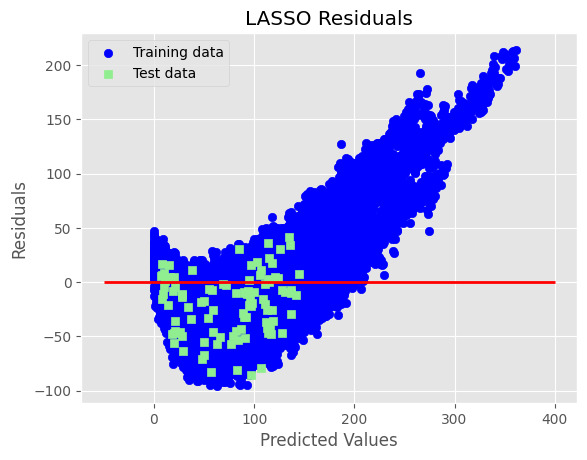

In [111]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

## **C.3 Ridge Regression :**

Just like with Lasso, we can use Ridge regression with built-in cross-validation to find the optimal value of the alpha parameter. In Ridge regression, alpha controls the strength of L2 regularization, which adds a penalty equal to the square of the magnitude of coefficients. This type of regularization tends to distribute the error among all the coefficients and is less likely to set coefficients to zero.

To implement this, we will use the RidgeCV class from the scikit-learn library.

In [112]:
from sklearn.linear_model import RidgeCV
alphas = [0.001, 0.01, 0.1, 1, 10, 100] #common to use values on a log scale
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
print("Best alpha value found:", best_alpha)

Best alpha value found: 1.0


In [113]:
rdg = linear_model.Ridge(alpha=1.0)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.547, R^2 test: 0.328


Ridge Regression
Root Mean Squared Error         34.077596
Mean Absolute Error             26.779848
R^2                              0.327522
Explained Variance               0.547875

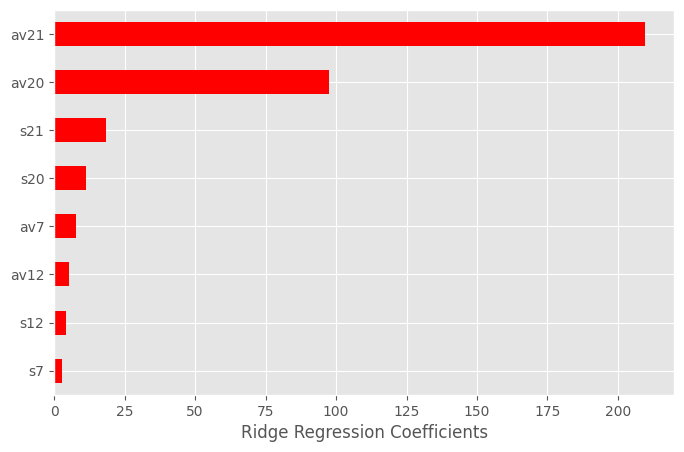

In [114]:
features_importance('Ridge Regression', rdg.coef_, X_train.columns, 'c')


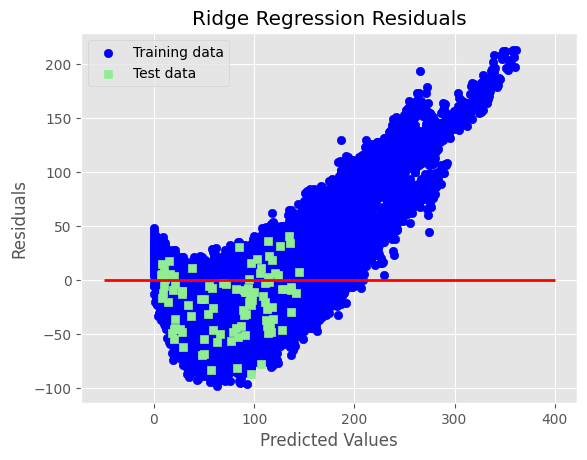

In [115]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)


## **C.4 Polynomial Regression :**


Polynomial regression is a form of regression analysis in which the relationship between the independent variable $x$ and the dependent variable $y$ is modeled as an nth degree polynomial. Polynomial regression fits a nonlinear relationship between the value of $x$ and the corresponding conditional mean of $y$, denoted $E(y | x)$, and has been used to describe nonlinear phenomena such as the growth rate of tissues, the distribution of carbon isotopes in lake sediments, and the progression of disease epidemics.

The basic equation of a polynomial regression is:

$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_n x^n + \epsilon $$

Here:
- $y$ is the dependent variable.
- $x$ is the independent variable.
- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are the coefficients.
- $n$ is the degree of the polynomial.
- $\epsilon$ is the error term.

**Hyperparameter: Degree**

The "degree" of the polynomial is a hyperparameter. It determines the flexibility of the polynomial regression model. Specifically:

1. **Degree 1**: The model is just a straight line (linear regression).
2. **Higher Degrees**: As you increase the degree of the polynomial, the model becomes more flexible and can fit more complex data patterns.


Here we're gonna choose degree=2, and transform the data to polynomial features using Polynomial features, and then use Linear regression on these polynomial features.

In [116]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.548, R^2 test: 0.333


Polynomial Regression
Root Mean Squared Error              33.931705
Mean Absolute Error                  26.549590
R^2                                   0.333267
Explained Variance                    0.547834

Here we couldn't use the features_importance function as it takes X.traincolumns as an argument, but here we transformed the features to polynomial.

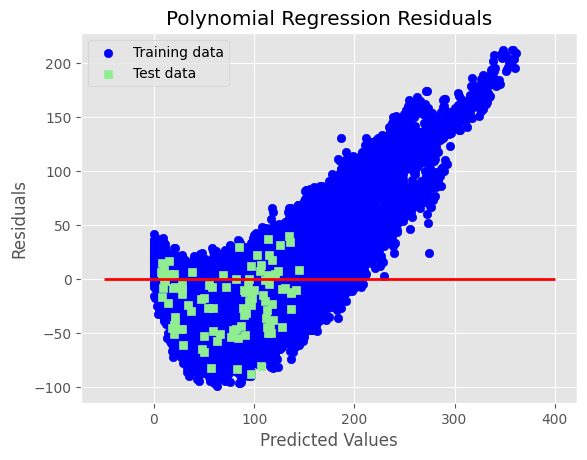

In [117]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)


## **C.5 Decision Tree regressor:**

The max depth in the Decision tree is a hyperparameter. We're gonna fix it to 10, as we have other parameters to change ( like the training features and the models).

In [118]:
dtrg = DecisionTreeRegressor(max_depth=10, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 0.628, R^2 test: 0.192


Decision Tree Regression
Root Mean Squared Error                 37.356893
Mean Absolute Error                     27.379659
R^2                                      0.191869
Explained Variance                       0.385668

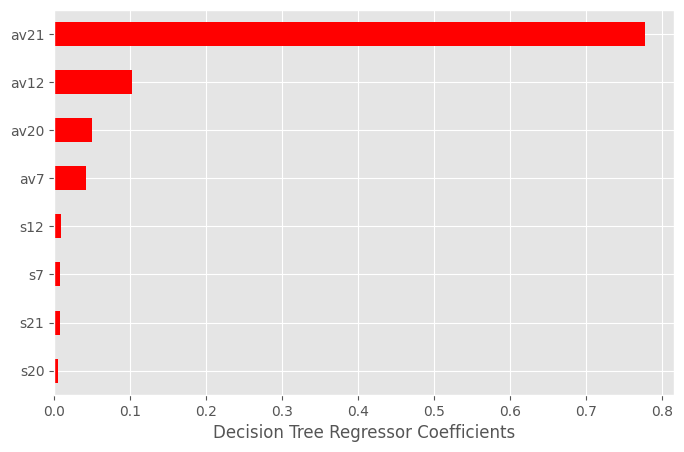

In [119]:
features_importance('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 'c' )


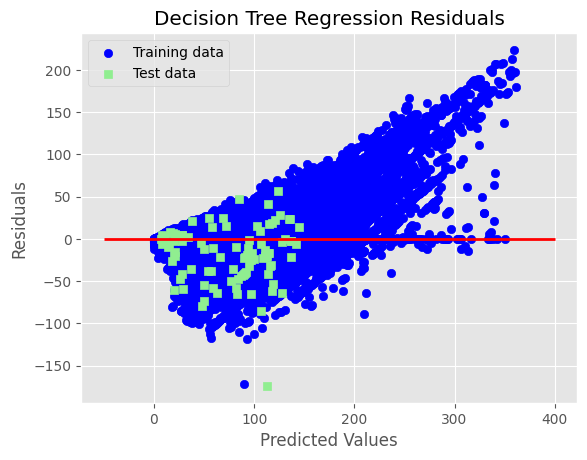

In [120]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)


Let's visualize the tree.

In [121]:
dot_data = export_graphviz(dtrg, out_file=None,
                           feature_names=X_train.columns,
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")

graph

## **C.6 Random Forest Regressor**

Choosing the best hyperparameters for a RandomForestRegressor (or any machine learning model) is typically done through a process known as hyperparameter tuning or optimization. This process involves searching through a range of hyperparameter values to find the combination that performs the best according to a specified metric, usually on a validation set or via cross-validation.

For a RandomForestRegressor, key hyperparameters include n_estimators, max_features, max_depth, and others. Let's use RandomizedSearchCV to find the best hyperparameters.

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV



param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 8, 10],
  }

rf = RandomForestRegressor(random_state=1)

rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                           n_iter=10, cv=3, verbose=2, random_state=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print("Best parameters found: ", rf_cv.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 5}


We first notice that it took too long to try the different combinations and just for 10 iterations.

In [123]:
rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=5, n_jobs=-1, random_state=1)

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.572, R^2 test: 0.324


Random Forest Regression
Root Mean Squared Error                 34.178601
Mean Absolute Error                     25.883633
R^2                                      0.323529
Explained Variance                       0.547968

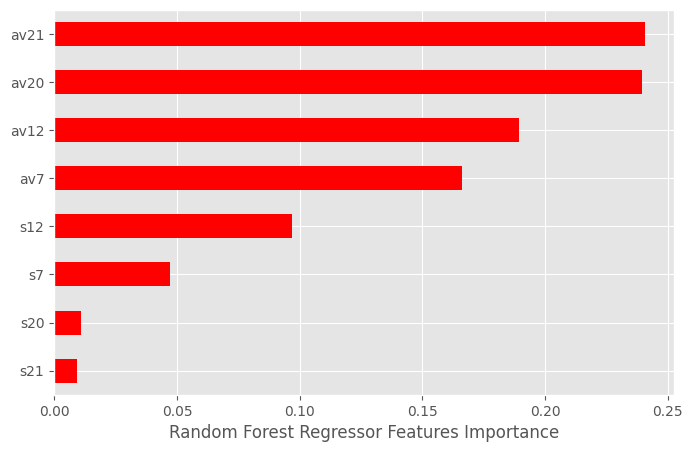

In [124]:
features_importance('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )


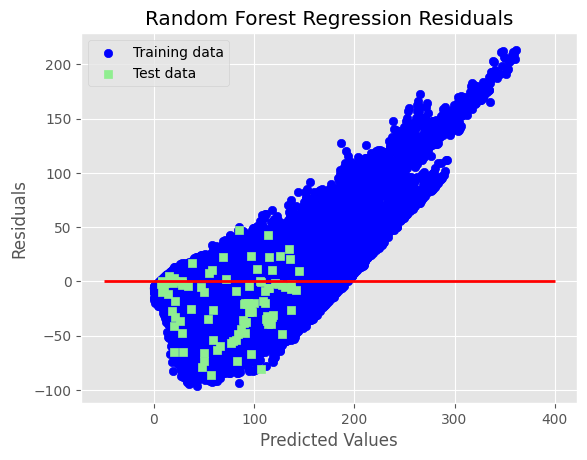

In [125]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)


##**Summary:**


Let us first compare the models.

In [126]:
reg_metrics_org = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics], axis=1)
reg_metrics_org

Linear Regression      LASSO  Ridge Regression  \
Root Mean Squared Error          34.121522  34.210798         34.077596   
Mean Absolute Error              26.829372  26.847588         26.779848   
R^2                               0.325787   0.322254          0.327522   
Explained Variance                0.546686   0.544830          0.547875   

                         Decision Tree Regression  Polynomial Regression  \
Root Mean Squared Error                 37.356893              33.931705   
Mean Absolute Error                     27.379659              26.549590   
R^2                                      0.191869               0.333267   
Explained Variance                       0.385668               0.547834   

                         Random Forest Regression  
Root Mean Squared Error                 34.178601  
Mean Absolute Error                     25.883633  
R^2                                      0.323529  
Explained Variance                       0.547968

- This time linear models got better than Random Forest. Ridge regression is the best model in this case with an RMSE of 34.077 .
- Regression residuals were not randomly spread across the average value of the residuals.
- For every model , av21 and av20 are always the most important features, and it's normal because they have high correlation with TTF.